<a href="https://colab.research.google.com/github/salmanromeo/ECEN_5513_Stochastic_Systems/blob/main/KF_KFS_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kalman filter**

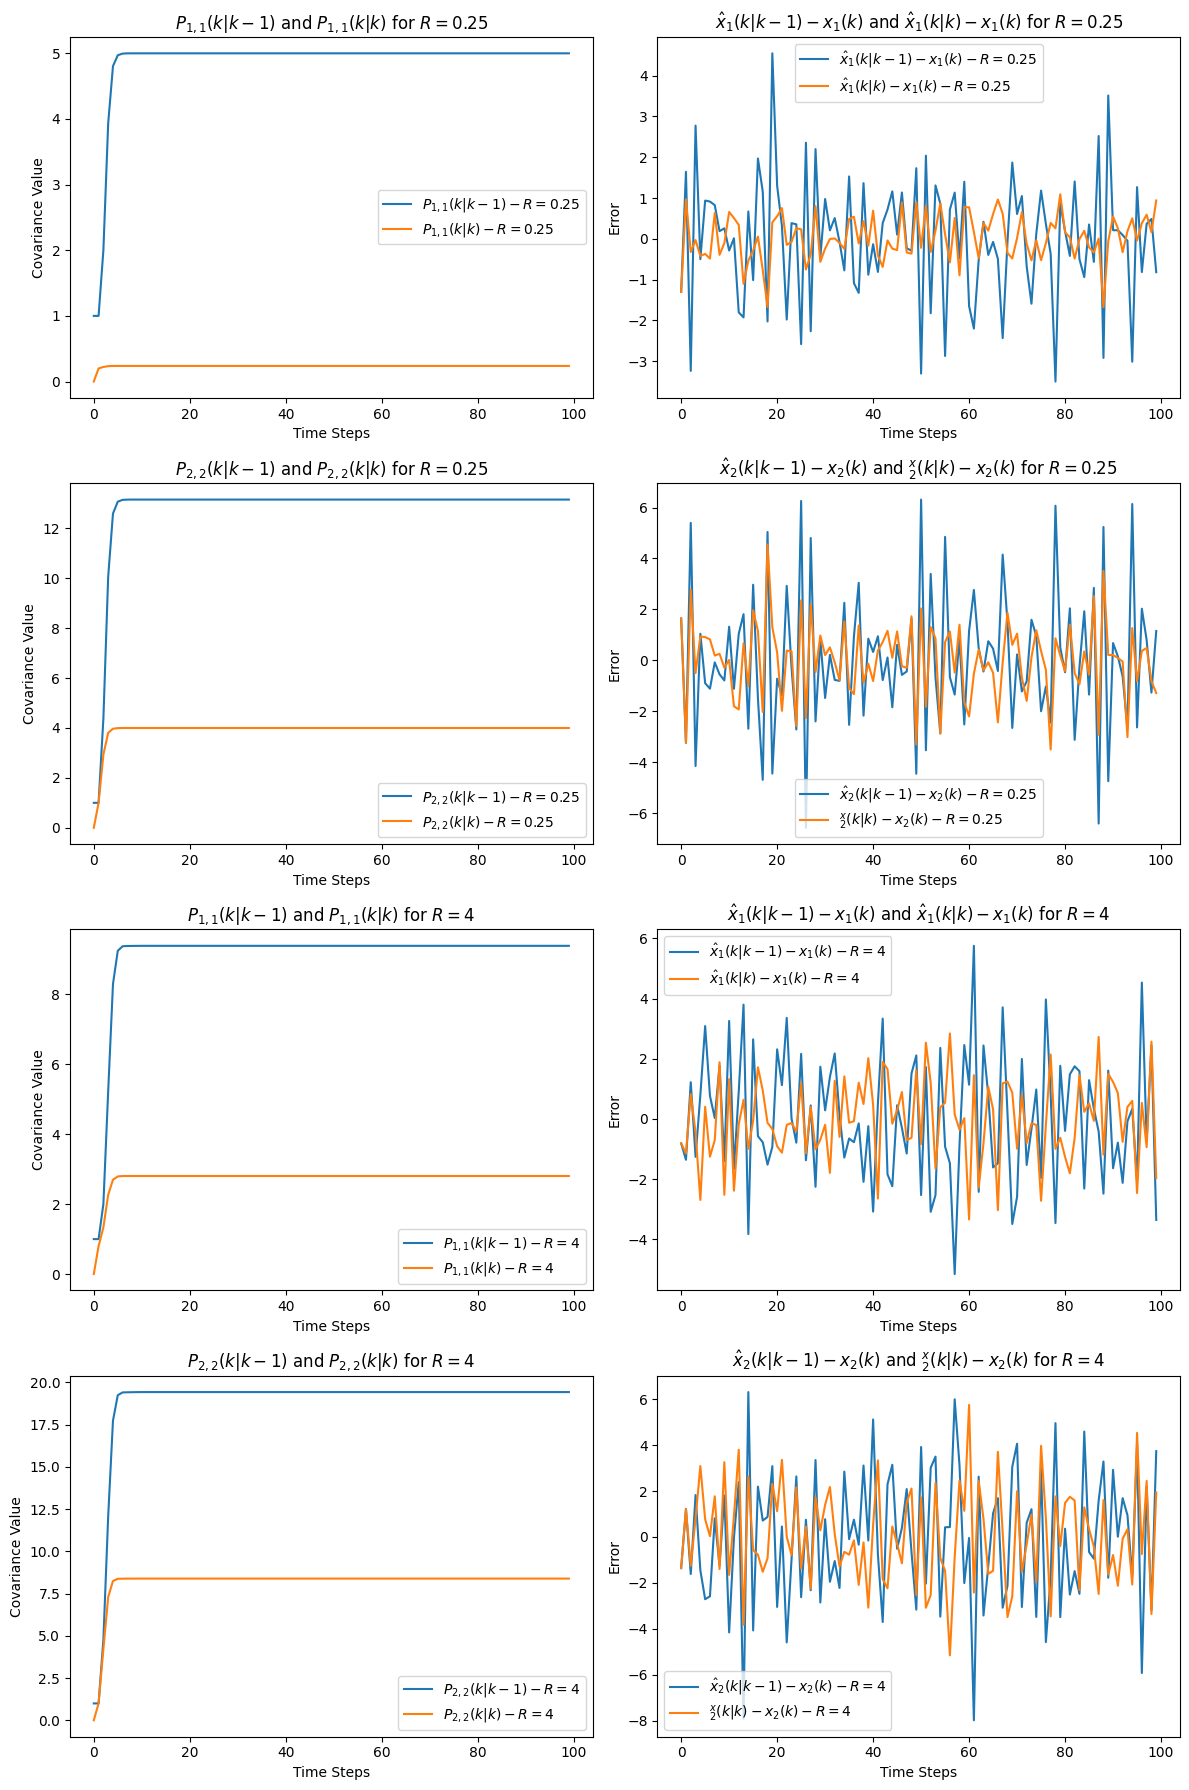

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_system(A, B, H, x0, Q, R, num_steps):
    n = A.shape[0]
    m = B.shape[1]

    x = np.zeros((n, num_steps))
    z = np.zeros((H.shape[0], num_steps))

    x[:, 0] = x0 + np.random.multivariate_normal(mean=np.zeros(n), cov=Q)
    for k in range(1, num_steps):
        x[:, k] = np.dot(A, x[:, k-1]) + np.dot(B, np.random.normal(size=m))
        z[:, k] = np.dot(H, x[:, k]) + np.random.normal(scale=np.sqrt(R))

    return x, z

def kalman_filter(A, B, H, x0, Q, R, num_steps):
    n = A.shape[0]
    m = B.shape[1]

    x_pred = np.zeros((n, num_steps))
    P_pred = np.zeros((n, n, num_steps))
    K = np.zeros((n, H.shape[0], num_steps))
    x_filter = np.zeros((n, num_steps))
    P_filter = np.zeros((n, n, num_steps))

    x_pred[:, 0] = x0
    P_pred[:, :, 0] = Q

    for k in range(1, num_steps):
        # Predictor step
        x_pred[:, k] = np.dot(A, x_filter[:, k-1])
        P_pred[:, :, k] = np.dot(np.dot(A, P_filter[:, :, k-1]), A.T) + Q

        # Kalman gain
        K[:, :, k] = np.dot(np.dot(P_pred[:, :, k], H.T), np.linalg.inv(np.dot(np.dot(H, P_pred[:, :, k]), H.T) + R))

        # Update step
        x_filter[:, k] = x_pred[:, k] + np.dot(K[:, :, k], (simulate_z[:, k] - np.dot(H, x_pred[:, k])))
        P_filter[:, :, k] = P_pred[:, :, k] - np.dot(np.dot(K[:, :, k], H), P_pred[:, :, k])

    return x_pred, P_pred, K, x_filter, P_filter

# Define system matrices
A = np.array([[0, 1], [-0.81, -1.8]])
B = np.array([[0], [1]])
H = np.array([[1, 0]])
x0 = np.array([0, 0])
Q = np.array([[1, 0], [0, 1]])
num_steps = 100

# Two cases for R
R_values = [0.25, 4]

plt.figure(figsize=(12, 18))

for i, R in enumerate(R_values):
    # Simulate system
    simulate_x, simulate_z = simulate_system(A, B, H, x0, Q, R, num_steps)

    # Kalman filter
    x_pred, P_pred, K, x_filter, P_filter = kalman_filter(A, B, H, x0, Q, R, num_steps)

    # Plot results for the first state variable
    plt.subplot(4, 2, i * 4 + 1)
    plt.plot(range(num_steps), P_pred[0, 0, :], label=f'$P_{{1,1}}(k | k-1) - R={R}$')
    plt.plot(range(num_steps), P_filter[0, 0, :], label=f'$P_{{1,1}}(k | k) - R={R}$')
    plt.title(f'$P_{{1,1}}(k | k-1)$ and $P_{{1,1}}(k | k)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Covariance Value')

    plt.subplot(4, 2, i * 4 + 2)
    plt.plot(range(num_steps), x_pred[0, :] - simulate_x[0, :], label=f'$\hat{{x}}_{{1}}(k | k-1) - x_{{1}}(k) - R={R}$')
    plt.plot(range(num_steps), x_filter[0, :] - simulate_x[0, :], label=f'$\hat{{x}}_{{1}}(k | k) - x_{{1}}(k) - R={R}$')
    plt.title(f'$\hat{{x}}_{{1}}(k | k-1) - x_{{1}}(k)$ and $\hat{{x}}_{{1}}(k | k) - x_{{1}}(k)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Error')

    # Plot results for the second state variable
    plt.subplot(4, 2, i * 4 + 3)
    plt.plot(range(num_steps), P_pred[1, 1, :], label=f'$P_{{2,2}}(k | k-1) - R={R}$')
    plt.plot(range(num_steps), P_filter[1, 1, :], label=f'$P_{{2,2}}(k | k) - R={R}$')
    plt.title(f'$P_{{2,2}}(k | k-1)$ and $P_{{2,2}}(k | k)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Covariance Value')

    plt.subplot(4, 2, i * 4 + 4)
    plt.plot(range(num_steps), x_pred[1, :] - simulate_x[1, :], label=f'$\hat{{x}}_{{2}}(k | k-1) - x_{{2}}(k) - R={R}$')
    plt.plot(range(num_steps), x_filter[1, :] - simulate_x[1, :], label=f'$^x_{{2}}(k | k) - x_{{2}}(k) - R={R}$')
    plt.title(f'$\hat{{x}}_{{2}}(k | k-1) - x_{{2}}(k)$ and $^x_{{2}}(k | k) - x_{{2}}(k)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Error')

plt.tight_layout()
plt.show()

**Kalman smoothing**

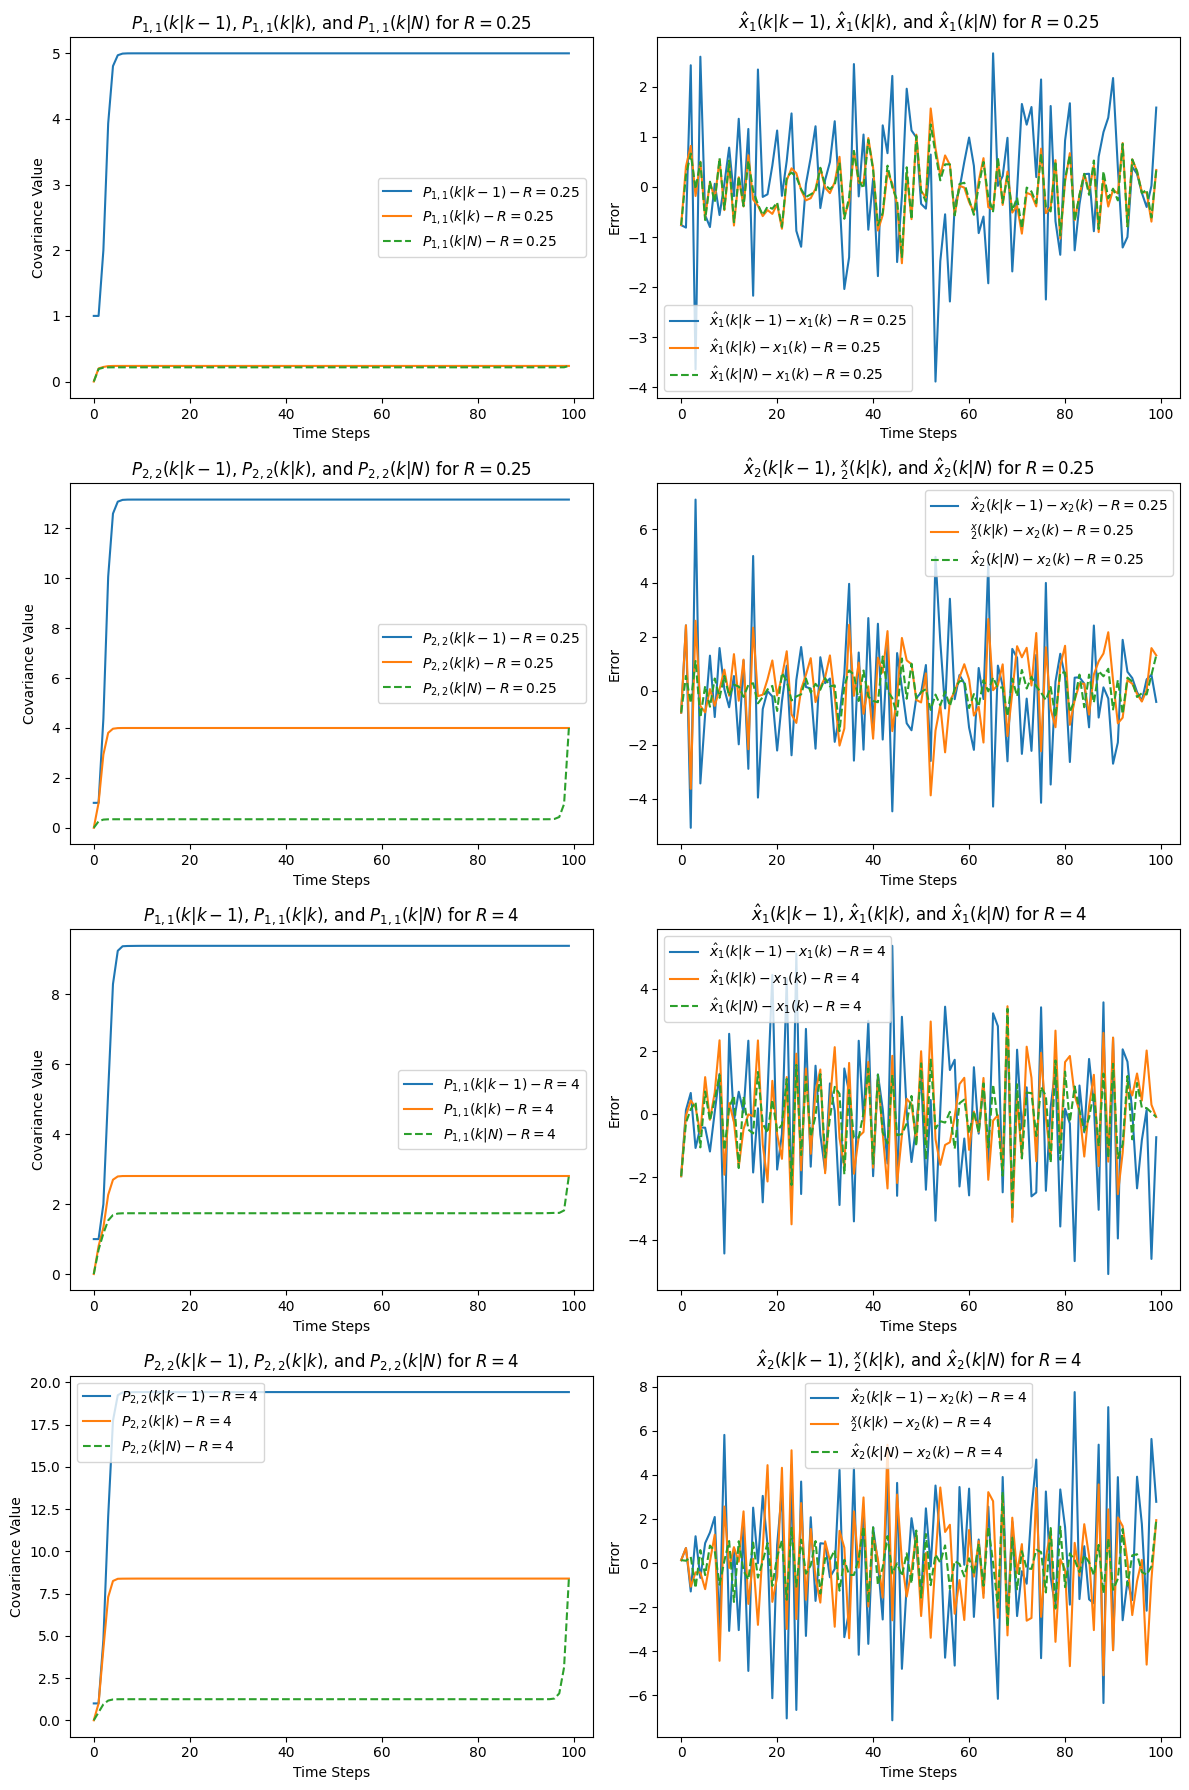

In [32]:
def kalman_smoother(A, B, H, Q, P_pred, K, x_pred, x_filter, P_filter):
    num_steps = len(P_pred[0, 0, :])

    # Initialize arrays for smoothed estimates
    x_smooth = np.zeros_like(x_filter)
    P_smooth = np.zeros_like(P_filter)

    # Initialize with the last filter estimate
    x_smooth[:, -1] = x_filter[:, -1]
    P_smooth[:, :, -1] = P_filter[:, :, -1]

    for k in range(num_steps - 2, -1, -1):
        # Smoothing gain
        J = np.matmul(P_filter[:, :, k], np.matmul(A.T, np.linalg.inv(P_pred[:, :, k + 1])))

        # Update smoothed estimate
        x_smooth[:, k] = x_filter[:, k] + np.matmul(J, (x_smooth[:, k + 1] - x_pred[:, k + 1]))

        # Update smoothed covariance
        P_smooth[:, :, k] = P_filter[:, :, k] + np.matmul(J, np.matmul((P_smooth[:, :, k + 1] - P_pred[:, :, k + 1]), J.T))

    return x_smooth, P_smooth

# Define system matrices
A = np.array([[0, 1], [-0.81, -1.8]])
B = np.array([[0], [1]])
H = np.array([[1, 0]])
x0 = np.array([0, 0])
Q = np.array([[1, 0], [0, 1]])
num_steps = 100

# Two cases for R
R_values = [0.25, 4]

plt.figure(figsize=(12, 18))

for i, R in enumerate(R_values):
    # Simulate system
    simulate_x, simulate_z = simulate_system(A, B, H, x0, Q, R, num_steps)

    # Kalman filter
    x_pred, P_pred, K, x_filter, P_filter = kalman_filter(A, B, H, x0, Q, R, num_steps)

    # Kalman smoother
    x_smooth, P_smooth = kalman_smoother(A, B, H, Q, P_pred, K, x_pred, x_filter, P_filter)

    # Plot results for the first state variable
    plt.subplot(4, 2, i * 4 + 1)
    plt.plot(range(num_steps), P_pred[0, 0, :], label=f'$P_{{1,1}}(k | k-1) - R={R}$')
    plt.plot(range(num_steps), P_filter[0, 0, :], label=f'$P_{{1,1}}(k | k) - R={R}$')
    plt.plot(range(num_steps), P_smooth[0, 0, :], label=f'$P_{{1,1}}(k | N) - R={R}$', linestyle='dashed')
    plt.title(f'$P_{{1,1}}(k | k-1)$, $P_{{1,1}}(k | k)$, and $P_{{1,1}}(k | N)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Covariance Value')

    plt.subplot(4, 2, i * 4 + 2)
    plt.plot(range(num_steps), x_pred[0, :] - simulate_x[0, :], label=f'$\hat{{x}}_{{1}}(k | k-1) - x_{{1}}(k) - R={R}$')
    plt.plot(range(num_steps), x_filter[0, :] - simulate_x[0, :], label=f'$\hat{{x}}_{{1}}(k | k) - x_{{1}}(k) - R={R}$')
    plt.plot(range(num_steps), x_smooth[0, :] - simulate_x[0, :], label=f'$\hat{{x}}_{{1}}(k | N) - x_{{1}}(k) - R={R}$', linestyle='dashed')
    plt.title(f'$\hat{{x}}_{{1}}(k | k-1)$, $\hat{{x}}_{{1}}(k | k)$, and $\hat{{x}}_{{1}}(k | N)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Error')

    # Plot results for the second state variable
    plt.subplot(4, 2, i * 4 + 3)
    plt.plot(range(num_steps), P_pred[1, 1, :], label=f'$P_{{2,2}}(k | k-1) - R={R}$')
    plt.plot(range(num_steps), P_filter[1, 1, :], label=f'$P_{{2,2}}(k | k) - R={R}$')
    plt.plot(range(num_steps), P_smooth[1, 1, :], label=f'$P_{{2,2}}(k | N) - R={R}$', linestyle='dashed')
    plt.title(f'$P_{{2,2}}(k | k-1)$, $P_{{2,2}}(k | k)$, and $P_{{2,2}}(k | N)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Covariance Value')

    plt.subplot(4, 2, i * 4 + 4)
    plt.plot(range(num_steps), x_pred[1, :] - simulate_x[1, :], label=f'$\hat{{x}}_{{2}}(k | k-1) - x_{{2}}(k) - R={R}$')
    plt.plot(range(num_steps), x_filter[1, :] - simulate_x[1, :], label=f'$^x_{{2}}(k | k) - x_{{2}}(k) - R={R}$')
    plt.plot(range(num_steps), x_smooth[1, :] - simulate_x[1, :], label=f'$\hat{{x}}_{{2}}(k | N) - x_{{2}}(k) - R={R}$', linestyle='dashed')
    plt.title(f'$\hat{{x}}_{{2}}(k | k-1)$, $^x_{{2}}(k | k)$, and $\hat{{x}}_{{2}}(k | N)$ for $R={R}$')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Error')

plt.tight_layout()
plt.show()

**MCMC**

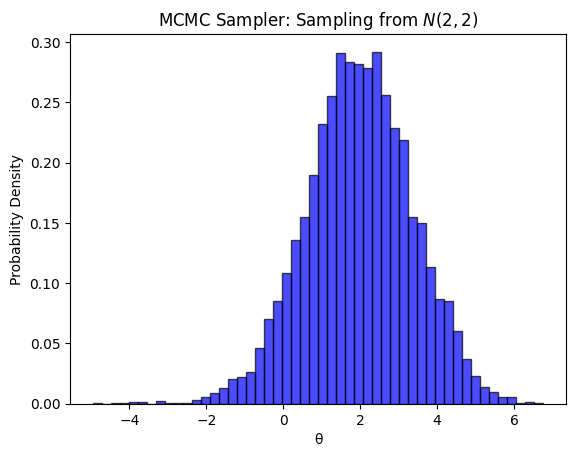

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution parameters
target_mean = 2
target_std = np.sqrt(2)

# Proposal distribution parameters
proposal_std = 1

# MCMC sampler function
def metropolis_hastings_sampler(num_samples, initial_theta):
    samples = np.zeros(num_samples)
    current_theta = initial_theta

    for i in range(num_samples):
        # Propose a new sample from the proposal distribution
        proposed_theta = np.random.normal(loc=current_theta, scale=proposal_std)

        # Calculate acceptance ratio
        acceptance_ratio = min(1, np.exp(-(proposed_theta - target_mean)**2 / (2 * target_std**2) +
                                          (current_theta - target_mean)**2 / (2 * target_std**2)))

        # Accept or reject the proposed sample
        if np.random.uniform() < acceptance_ratio:
            current_theta = proposed_theta

        samples[i] = current_theta

    return samples

# MCMC parameters
total_samples = 10000
burn_in_percentage = 0.1
burn_in_steps = int(total_samples * burn_in_percentage)

# Initialize sampler with θ = 0
initial_theta = 0

# Run MCMC sampler
samples = metropolis_hastings_sampler(total_samples, initial_theta)

# Discard the burn-in samples
samples = samples[burn_in_steps:]

# Plot histogram of the remaining samples
plt.hist(samples, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('MCMC Sampler: Sampling from $N(2, 2)$')
plt.xlabel('θ')
plt.ylabel('Probability Density')
plt.show()